In [1]:
import pandas as pd

# Cargar archivos
cobros = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroDetalleUnido.csv")
estrategias = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroEmisora.csv")
respuestas = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatRespuestaBancos.csv")
capital_pagare = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/Capital_Pagare_FechaAperturaCredito.csv")

# Enriquecer con estrategia usada
cobros = cobros.merge(estrategias, on="idListaCobro", how="left")

# Enriquecer con descripción de respuesta del banco
cobros = cobros.merge(respuestas, left_on="idRespuestaBanco", right_on="IdRespuestaBanco", how="left")

# Enriquecer con columna capital y columna pagare. de capital_pagare segun columna idCredito en cobros y idCredito en capital_pagare
cobros = cobros.merge(capital_pagare, left_on="idCredito", right_on="idcredito", how="left")


# Marcar si fue exitoso
cobros["esExitoso"] = cobros["montoCobrado"] > 0

# Clasificar respuesta en categorías generales
def clasificar_respuesta(row):
    if row["idRespuestaBanco"] == "00":
        return "exitosa"
    elif row["Descripcion"] in ["Cuenta Cancelada", "Cuenta Bloqueada", "Cuenta Inexistente"]:
        return "cuenta_invalida"
    elif row["montoCobrado"] > 0:
        return "parcial"
    else:
        return "otros"

cobros["respuestaCategoria"] = cobros.apply(clasificar_respuesta, axis=1)

# Sort por esExitoso True 
cobros = cobros.sort_values(by=["esExitoso", "idListaCobro", "idRespuestaBanco"], ascending=[False, True, True])

cobros.head()


/var/folders/nq/zht86vzj6n5g3py55h5xd7xr0000gn/T/ipykernel_5282/1127127287.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  cobros = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroDetalleUnido.csv")


,idListaCobro,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,idEmisora,IdRespuestaBanco,Descripcion,idcredito,pagare,capital,fechaAperturaCredito,esExitoso,respuestaCategoria
52431,79678,291172,23794381,44,275.50,275.50,275.50,04/01/2022,00,20,00,Domiciliacion Exitosa,291172.0,35815.00,12700.00,03/08/2015,True,exitosa
52327,80111,459208,23840286,21,720.36,720.36,720.36,11/01/2022,00,20,00,Domiciliacion Exitosa,459208.0,51865.92,23022.87,28/09/2018,True,exitosa
52340,80111,495309,23840297,21,225.87,225.87,225.87,11/01/2022,00,20,00,Domiciliacion Exitosa,495309.0,58643.52,21960.57,17/06/2019,True,exitosa
52345,80111,507710,23840301,21,833.37,833.37,833.37,11/01/2022,00,20,00,Domiciliacion Exitosa,507710.0,149914.80,66545.99,27/08/2019,True,exitosa
52353,80111,525580,23840309,21,483.91,483.91,483.91,11/01/2022,00,20,00,Domiciliacion Exitosa,525580.0,150198.88,60000.00,30/11/2019,True,exitosa


In [2]:
print(cobros.shape)
# Drop columnas innecesarias: idListaCobro, fechaCobroBanco, IdRespuestaBanco
cobros.drop(columns=["idListaCobro", "fechaCobroBanco", "IdRespuestaBanco", "idcredito"], inplace=True)
# Drop NaN values
cobros.dropna(subset=["idRespuestaBanco"], inplace=True)
print(cobros.shape)

(10057440, 18)
(9907879, 14)


In [3]:
#  mostrar valores unicos en idEmisora
print(cobros["idEmisora"].unique())

[20 19 68 78 25 21 23 24 34  1 36 51 79 62 75 10  2 13  9 12 17  5  6 15
 22 18 14 16 45  4 11  3  7]


In [4]:
# Cargar tabla de costos por estrategia
costos = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatEmisora.csv")

# Asegurarse de que los nombres de columnas están bien
costos.columns = costos.columns.str.strip()  # quitar espacios accidentales
costos["cobraSoloExitoso"] = costos["cobraSoloExitoso"].astype(bool)

# Unir al dataframe de cobros por 'idEmisora'
cobros = cobros.merge(costos[["idEmisora", "costo", "cobraSoloExitoso"]], on="idEmisora", how="left")

# Calcular el costo real de cada intento según si se cobra solo por éxito o siempre
def calcular_costo_transaccion(row):
    if row["cobraSoloExitoso"]:
        return row["costo"] if row["esExitoso"] else 0
    else:
        return row["costo"]

cobros["costoTransaccion"] = cobros.apply(calcular_costo_transaccion, axis=1)

cobros_exitosos = cobros[cobros["esExitoso"]].groupby("idEmisora").size().reset_index(name="cantidadExitosos")
print(cobros_exitosos)

# Drop todos los idEmisora que tengan menos de 50 esExitoso True
# Calcular el total de éxitos por estrategia
exitos_por_estr = cobros.groupby("idEmisora")["esExitoso"].sum()

# Identificar idEmisora con al menos 50 éxitos
estr_validas = exitos_por_estr[exitos_por_estr >= 500].index

# Filtrar el DataFrame eliminando las estrategias con menos de 50 éxitos
cobros_filtrado = cobros[cobros["idEmisora"].isin(estr_validas)].copy()



    idEmisora  cantidadExitosos
0           1             15839
1           2              1734
2           5             39254
3           6             19203
4           9             48489
5          10             14650
6          12             17380
7          13              1980
8          14                 6
9          15               349
10         16                81
11         17             53967
12         18              2502
13         19              1551
14         20              1735
15         21             32294
16         22              2003
17         23              4529
18         24               496
19         25              8836
20         34              1218
21         36              5261
22         51               145
23         62              1201
24         68              8414
25         75               187
26         78                21
27         79             10584


In [5]:
cobros = cobros_filtrado.copy()
# Cantidad de cobros exitosos en idEmisora == 1
cobros_exitosos = cobros[cobros["esExitoso"]].groupby("idEmisora").size().reset_index(name="cantidadExitosos")
print(cobros_exitosos)

    idEmisora  cantidadExitosos
0           1             15839
1           2              1734
2           5             39254
3           6             19203
4           9             48489
5          10             14650
6          12             17380
7          13              1980
8          17             53967
9          18              2502
10         19              1551
11         20              1735
12         21             32294
13         22              2003
14         23              4529
15         25              8836
16         34              1218
17         36              5261
18         62              1201
19         68              8414
20         79             10584


In [6]:
# Ordenar por crédito y consecutivoCobro
cobros = cobros.sort_values(by=["idCredito", "consecutivoCobro"])

# Calcular número de intento por crédito
cobros["num_intento"] = cobros.groupby("idCredito").cumcount() + 1
cobros["es_segundo_intento"] = cobros["num_intento"] == 2
cobros["num_exitos_previos"] = cobros.groupby("idCredito")["esExitoso"].cumsum() - cobros["esExitoso"].astype(int)
cobros["num_intentos_previos"] = cobros["num_intento"] - 1

cobros.head()

,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,idRespuestaBanco,idEmisora,Descripcion,pagare,...,fechaAperturaCredito,esExitoso,respuestaCategoria,costo,cobraSoloExitoso,costoTransaccion,num_intento,es_segundo_intento,num_exitos_previos,num_intentos_previos
1426581,6,32697369,2,375.47,375.47,0.0,4.0,23,NaN,27033.84,...,12/03/2012,False,otros,1.91,True,0.0,1,False,0,0
4188990,3674,36776754,72,344.18,344.18,0.0,1.0,12,NaN,24780.96,...,29/03/2012,False,otros,2.50,False,2.5,1,False,0,0
314593,4635,27248919,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,32665.68,...,02/04/2012,False,otros,6.00,True,0.0,1,False,0,0
328303,4635,29393671,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,32665.68,...,02/04/2012,False,otros,6.00,True,0.0,2,True,0,1
388055,4635,29600474,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,32665.68,...,02/04/2012,False,otros,6.00,True,0.0,3,False,0,2


In [7]:
# Proporcion de intentos exitosos segun columna esExitoso 
exitosos = cobros[cobros["esExitoso"] == True]
fallidos = cobros[cobros["esExitoso"] == False]
print("Proporción de intentos exitosos:", len(exitosos) / (len(exitosos) + len(fallidos)))



Proporción de intentos exitosos: 0.02962948562328399


In [ ]:
cobros.groupby("idEmisora")["esExitoso"].agg(["count", "sum"]).assign(tasa=lambda df: df["sum"] / df["count"]).sort_values("sum", ascending=False)


,count,sum,tasa
idEmisora,,,
17,222739,53967,0.242288
9,125829,48489,0.385356
5,2227362,39254,0.017624
21,1327258,32294,0.024331
6,3316858,19203,0.005790
12,160604,17380,0.108216
1,654165,15839,0.024213
10,249965,14650,0.058608
79,61892,10584,0.171008


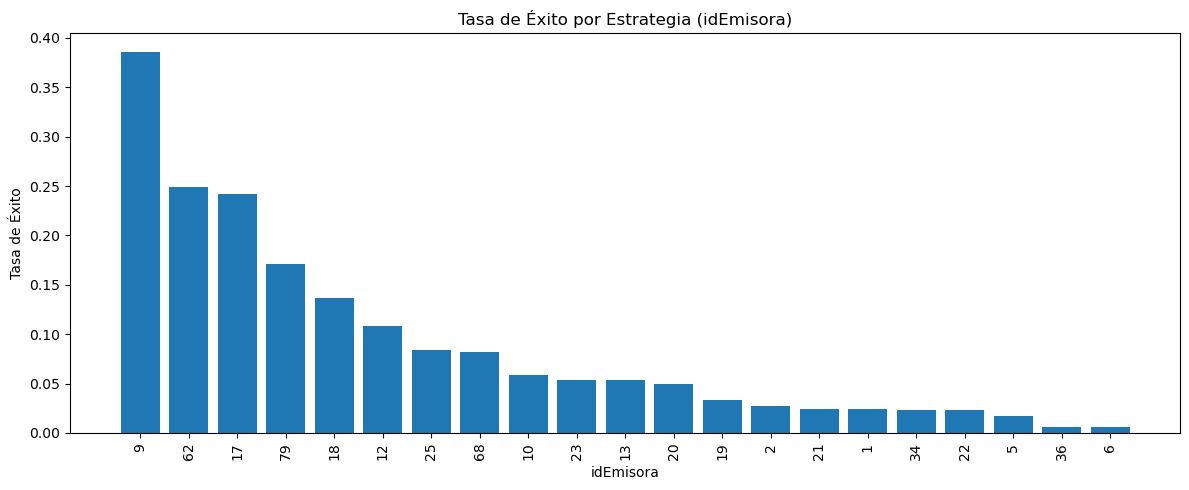

idEmisora
9     0.385356
62    0.248706
17    0.242288
79    0.171008
18    0.136691
12    0.108216
25    0.084179
68    0.082258
10    0.058608
23    0.053820
13    0.053801
20    0.049829
19    0.033716
2     0.027183
21    0.024331
1     0.024213
34    0.023679
22    0.023671
5     0.017624
36    0.005862
6     0.005790
Name: tasa_exito, dtype: float64
idBanco         2         12        14        21        30        36   \
idEmisora                                                               
1          0.024210  0.500000       NaN       NaN       NaN       NaN   
2          0.027183       NaN       NaN       NaN       NaN       NaN   
5          0.017624       NaN       NaN       NaN       NaN       NaN   
6               NaN  0.005016       NaN  0.033146  0.034979  0.029762   
9               NaN       NaN  0.385356       NaN       NaN       NaN   
10              NaN       NaN  0.058608       NaN       NaN       NaN   
12              NaN       NaN       NaN       NaN       Na

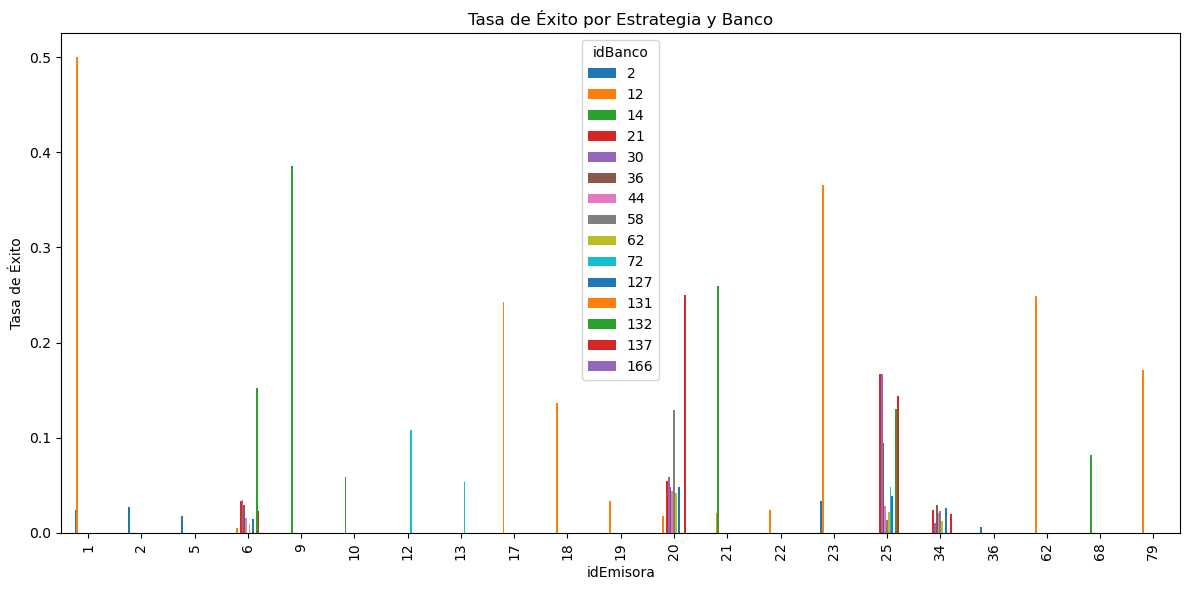

idEmisora
9     0.491210
17    0.300177
18    0.144092
79    0.130052
12    0.119522
62    0.076375
68    0.072704
25    0.072130
13    0.057462
20    0.039952
19    0.039228
10    0.034968
1     0.034420
21    0.032351
23    0.028803
22    0.025726
34    0.020581
5     0.019735
2     0.019619
6     0.007266
36    0.005158
Name: tasa_recuperacion, dtype: float64


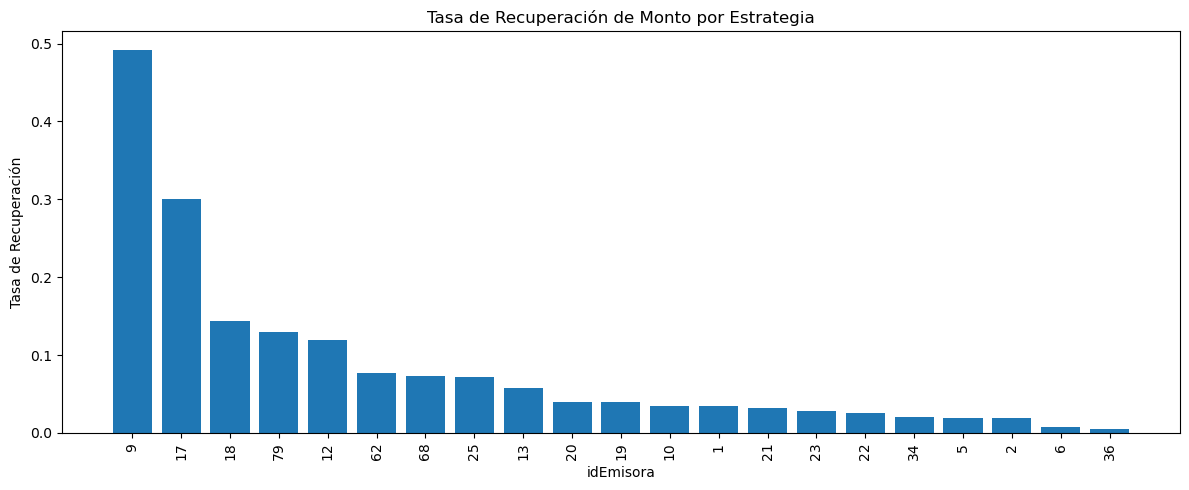

Tasa de éxito en el segundo intento: 18.10%

Distribución de respuestas del banco en segundo intento:
respuestaCategoria
otros              0.806341
parcial            0.141857
exitosa            0.039155
cuenta_invalida    0.012647
Name: proportion, dtype: float64
idEmisora
9     0.607547
17    0.408949
12    0.269715
21    0.250754
2     0.244186
10    0.216334
22    0.205357
1     0.199216
79    0.193355
68    0.164647
25    0.142618
62    0.123364
13    0.104727
23    0.093848
19    0.064516
34    0.061333
20    0.058626
6     0.040325
36    0.017712
5     0.015866
18    0.000000
Name: tasa_exito, dtype: float64


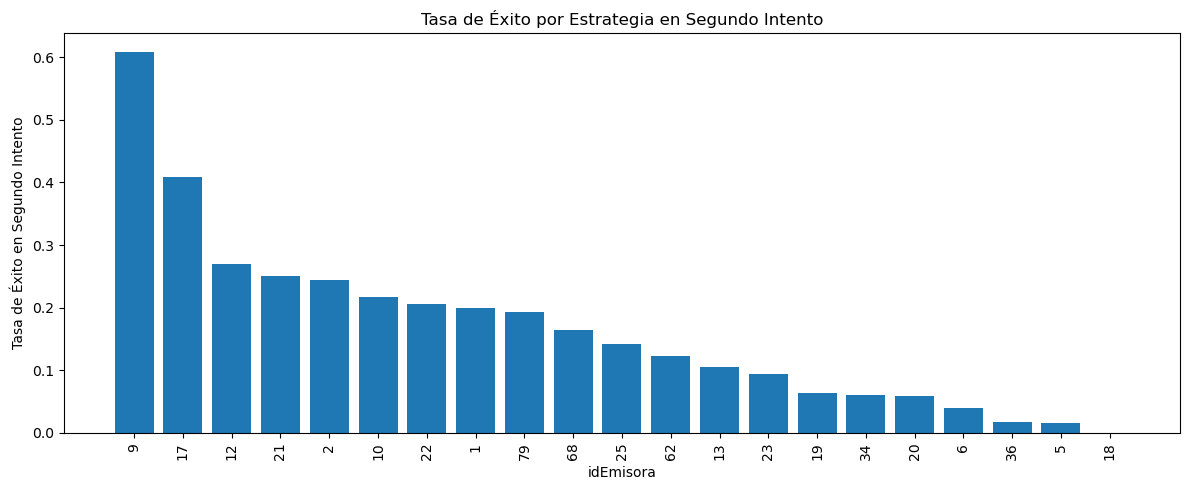

idCredito
4635      11
10983      4
18749      4
19635     14
25720     41
          ..
755672     1
755683     1
755695     1
755726     1
756595     5
Name: num_intento, Length: 40160, dtype: int64


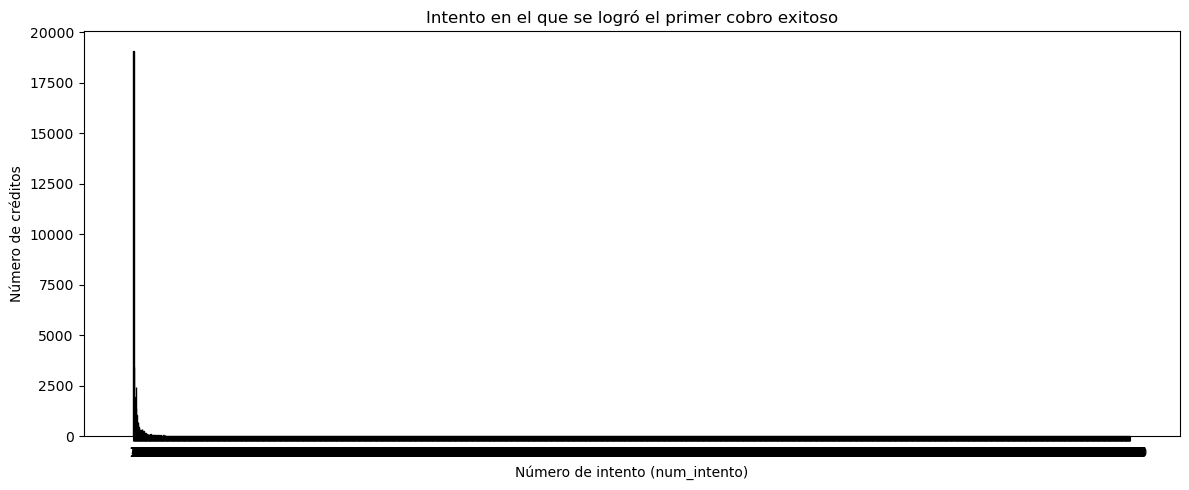

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# === 1. Tasa de Éxito por Estrategia (idEmisora) ===
exito_por_estrategia = cobros.groupby("idEmisora")["esExitoso"].agg(["count", "sum"])
exito_por_estrategia["tasa_exito"] = exito_por_estrategia["sum"] / exito_por_estrategia["count"]
exito_por_estrategia = exito_por_estrategia.sort_values("tasa_exito", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(exito_por_estrategia.index.astype(str), exito_por_estrategia["tasa_exito"])
plt.title("Tasa de Éxito por Estrategia (idEmisora)")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# === 2. Tasa de Éxito por Banco y Estrategia ===
exito_banco_estrategia = cobros.groupby(["idBanco", "idEmisora"])["esExitoso"].agg(["count", "sum"])
exito_banco_estrategia["tasa_exito"] = exito_banco_estrategia["sum"] / exito_banco_estrategia["count"]
pivot_be = exito_banco_estrategia.reset_index().pivot(index="idEmisora", columns="idBanco", values="tasa_exito")

pivot_be.plot(kind="bar", figsize=(12, 6))
plt.title("Tasa de Éxito por Estrategia y Banco")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito")
plt.xticks(rotation=90)
plt.legend(title="idBanco")
plt.tight_layout()
plt.show()

# === 3. Tasa de Recuperación de Monto por Estrategia ===
monto_estrategia = cobros.groupby("idEmisora")[["montoExigible", "montoCobrado"]].sum()
monto_estrategia["tasa_recuperacion"] = monto_estrategia["montoCobrado"] / monto_estrategia["montoExigible"]
monto_estrategia = monto_estrategia.sort_values("tasa_recuperacion", ascending=False)

print(monto_estrategia["tasa_recuperacion"])
plt.figure(figsize=(12, 5))
plt.bar(monto_estrategia.index.astype(str), monto_estrategia["tasa_recuperacion"])
plt.title("Tasa de Recuperación de Monto por Estrategia")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Recuperación")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === 4. Análisis de SEGUNDO intento de cobranza ===
segundos = cobros[cobros["es_segundo_intento"] == True]

# Tasa de éxito en el segundo intento
tasa_exito_segundo = segundos["esExitoso"].mean()

# Comparar estrategias más comunes en segundo intento
estrategias_segundo = segundos.groupby("idEmisora")["esExitoso"].agg(["count", "sum"])
estrategias_segundo["tasa_exito"] = estrategias_segundo["sum"] / estrategias_segundo["count"]
estrategias_segundo = estrategias_segundo.sort_values("tasa_exito", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(estrategias_segundo.index.astype(str), estrategias_segundo["tasa_exito"])
plt.title("Tasa de Éxito por Estrategia en Segundo Intento")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito en Segundo Intento")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === 5. Análisis de intentos acumulados antes de éxito ===
# Solo intentos exitosos
exitos = cobros[cobros["esExitoso"] == True]

# Para cada crédito exitoso, ¿en qué intento lo logró?
primer_exito = exitos.groupby("idCredito")["num_intento"].min()

plt.figure(figsize=(12, 5))
plt.hist(primer_exito, bins=range(1, primer_exito.max()+2), edgecolor='black')
plt.title("Intento en el que se logró el primer cobro exitoso")
plt.xlabel("Número de intento (num_intento)")
plt.ylabel("Número de créditos")
plt.xticks(range(1, primer_exito.max()+1))
plt.tight_layout()
plt.show()


In [10]:
# Verifica si alguna estrategia exitosa tiene costo == 0
cobros[(cobros["montoCobrado"] > 0) & (cobros["costoTransaccion"] == 0)][["idEmisora", "esExitoso", "costo", "montoCobrado","cobraSoloExitoso"]].value_counts()


Series([], Name: count, dtype: int64)

In [11]:
# %%
# Agrupar métricas por estrategia
estrategias_eval = cobros.groupby("idEmisora").agg(
    total_intentos=("idCredito", "count"),
    total_exitos=("esExitoso", "sum"),
    monto_total_cobrado=("montoCobrado", "sum"),
    costo_total=("costoTransaccion", "sum")
)

# Métricas adicionales
estrategias_eval["tasa_exito"] = estrategias_eval["total_exitos"] / estrategias_eval["total_intentos"]
estrategias_eval["roi"] = estrategias_eval["monto_total_cobrado"] / estrategias_eval["costo_total"]
estrategias_eval["efectividad_ajustada"] = (estrategias_eval["monto_total_cobrado"] - estrategias_eval["costo_total"]) / estrategias_eval["total_intentos"]

estrategias_eval = estrategias_eval.sort_values("efectividad_ajustada", ascending=False)
estrategias_eval.reset_index(inplace=True)

# Mostrar top 10 estrategias
estrategias_eval.head(50)


,idEmisora,total_intentos,total_exitos,monto_total_cobrado,costo_total,tasa_exito,roi,efectividad_ajustada
0,9,125829,48489,37746119.43,354837.78,0.385356,106.375706,297.159491
1,17,222739,53967,46906100.02,431736.00,0.242288,108.645330,208.649424
2,79,61892,10584,7866147.81,84672.00,0.171008,92.901406,125.726682
3,12,160604,17380,16982801.02,401510.00,0.108216,42.297330,103.243325
4,18,18304,2502,1586420.99,20016.00,0.136691,79.257643,85.577196
5,25,104967,8836,8767382.30,53016.00,0.084179,165.372384,83.020057
6,62,4829,1201,272046.47,2293.91,0.248706,118.595093,55.860957
7,68,102288,8414,5106113.87,288452.16,0.082258,17.701770,47.098992
8,20,34819,1735,1557121.52,13880.00,0.049829,112.184548,44.321822
9,10,249965,14650,9813669.49,704901.30,0.058608,13.922048,36.440174


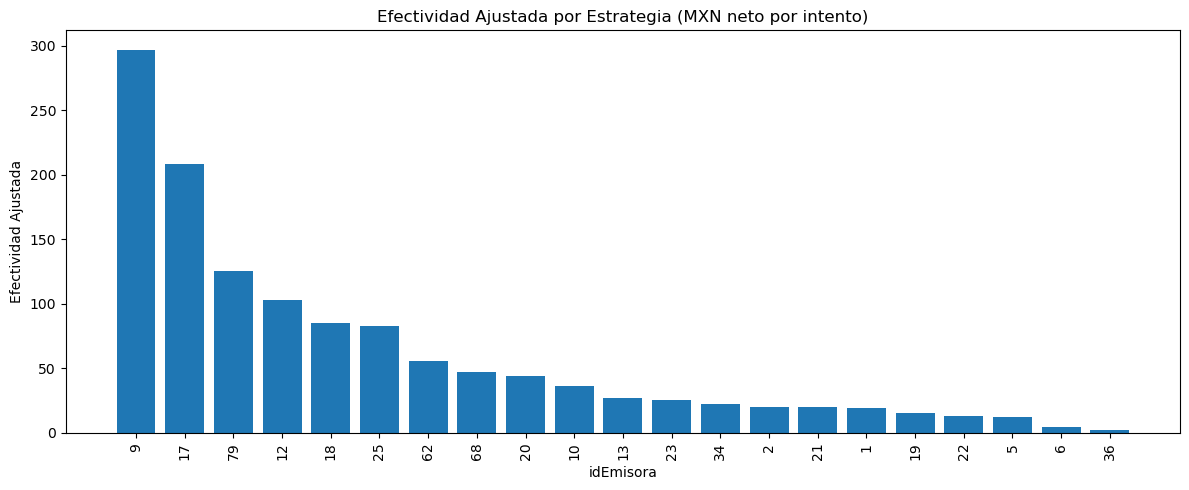

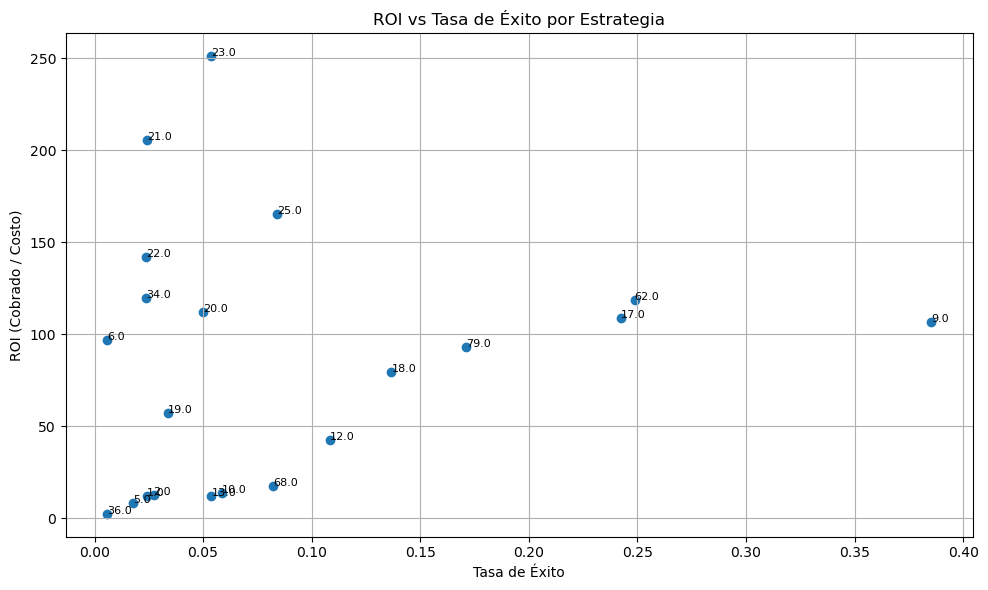

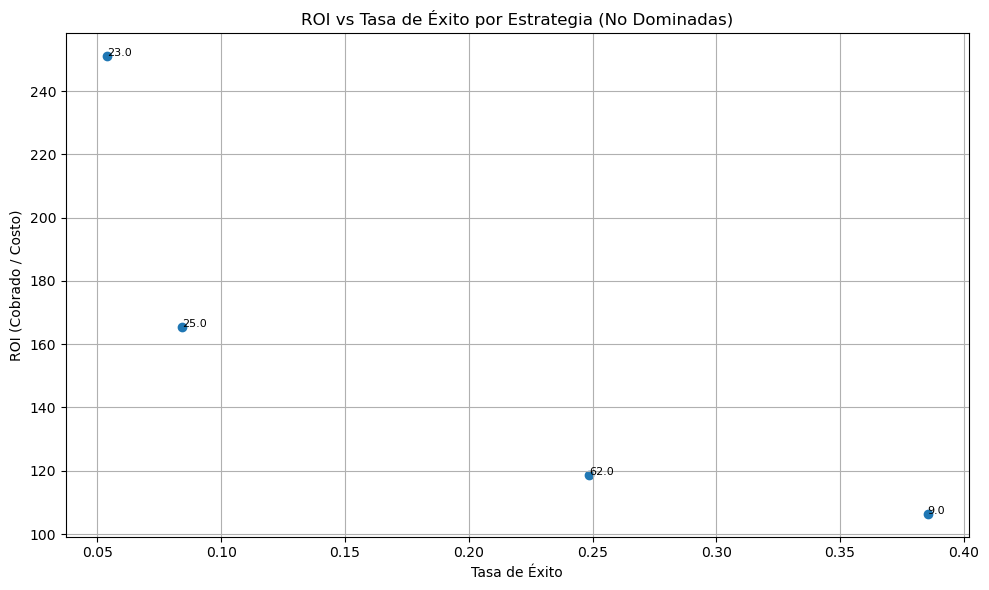

In [12]:
# %%
# Gráfico: Efectividad ajustada
plt.figure(figsize=(12, 5))
plt.bar(estrategias_eval["idEmisora"].astype(str), estrategias_eval["efectividad_ajustada"])
plt.title("Efectividad Ajustada por Estrategia (MXN neto por intento)")
plt.xlabel("idEmisora")
plt.ylabel("Efectividad Ajustada")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Gráfico: ROI vs Tasa de Éxito
plt.figure(figsize=(10, 6))
plt.scatter(estrategias_eval["tasa_exito"], estrategias_eval["roi"])
for i, row in estrategias_eval.iterrows():
    plt.text(row["tasa_exito"], row["roi"], str(row["idEmisora"]), fontsize=8)
plt.xlabel("Tasa de Éxito")
plt.ylabel("ROI (Cobrado / Costo)")
plt.title("ROI vs Tasa de Éxito por Estrategia")
plt.grid(True)
plt.tight_layout()
plt.show()

# ——— Cálculo correcto de no dominadas por Pareto ———
import numpy as np

# Extraemos las dos métricas en arrays para vectorizar un poco
tasa = estrategias_eval["tasa_exito"].values
roi  = estrategias_eval["roi"].values

# Para cada índice i, vemos si existe j != i que domine i
is_dominated = np.zeros(len(estrategias_eval), dtype=bool)
for i in range(len(estrategias_eval)):
    # mascarilla de todos menos el mismo
    others = np.arange(len(estrategias_eval)) != i
    # ¿algún otro j cumple?
    domina = (
        (tasa[others] >= tasa[i]) &
        (roi [others] >= roi [i]) &
        ( (tasa[others] > tasa[i]) | (roi[others] > roi[i]) )
    )
    if domina.any():
        is_dominated[i] = True

# Filtramos sólo las no dominadas
estr_no_dom = estrategias_eval[~is_dominated].copy()

# ——— Plotting ———
plt.figure(figsize=(10, 6))
plt.scatter(estr_no_dom["tasa_exito"], estr_no_dom["roi"])
for _, row in estr_no_dom.iterrows():
    plt.text(row["tasa_exito"], row["roi"], str(row["idEmisora"]), fontsize=8)
plt.xlabel("Tasa de Éxito")
plt.ylabel("ROI (Cobrado / Costo)")
plt.title("ROI vs Tasa de Éxito por Estrategia (No Dominadas)")
plt.grid(True)
plt.tight_layout()
plt.show()




=== Classification Report (con class_weight='balanced') ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99   2875046
           1       0.58      0.36      0.44     87787

    accuracy                           0.97   2962833
   macro avg       0.78      0.67      0.71   2962833
weighted avg       0.97      0.97      0.97   2962833

AUC: 0.8879


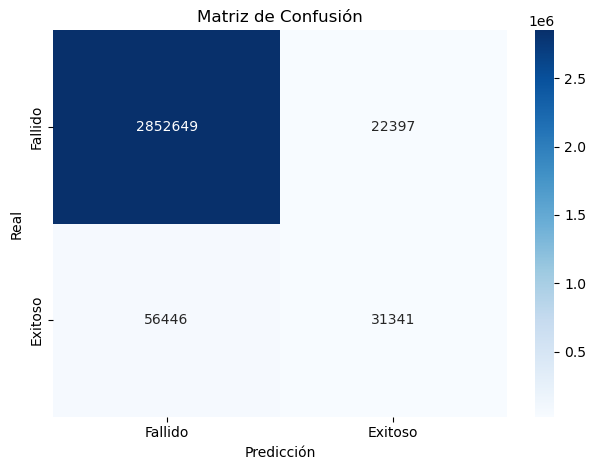

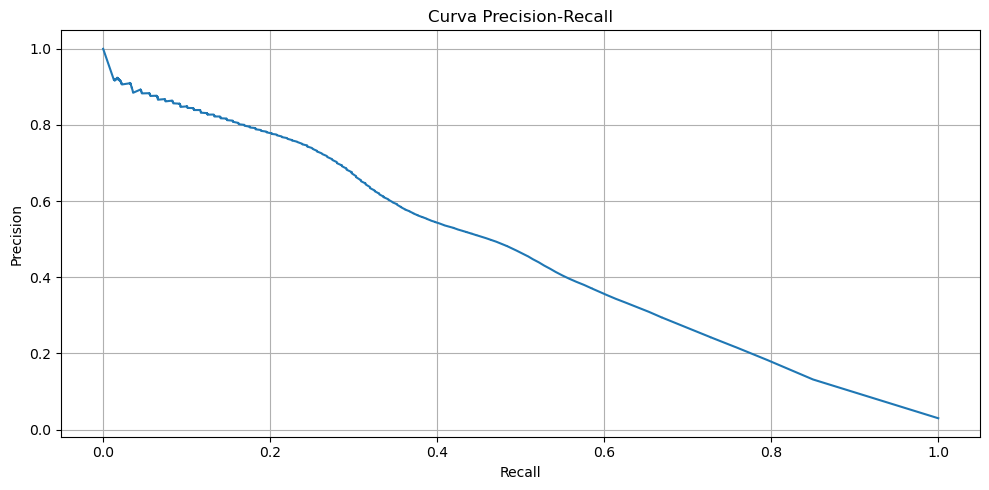

In [13]:
# %%
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Variables para el modelo, incluyendo información financiera
vars_modelo = [
    "idEmisora", "montoExigible", "montoCobrar",
    "num_intentos_previos", "num_exitos_previos", "es_segundo_intento",
    "costo", "cobraSoloExitoso", "pagare", "capital"
]

# Preparar X e y
cobros10 = cobros
X = cobros10[vars_modelo]
y = cobros10["esExitoso"].astype(int)

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=["idEmisora", "cobraSoloExitoso"])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo con ajuste por desbalance
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# === Evaluación ===
print("\n=== Classification Report (con class_weight='balanced') ===")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fallido", "Exitoso"], yticklabels=["Fallido", "Exitoso"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curva de precisión vs recall ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
def simular_estrategias_por_credito(
    ejemplos_base, clf, X_model_columns, estr_info,
    umbral=0.05
):
    """
    Simula la elección óptima de estrategia para un conjunto de créditos dados.
    
    Parámetros:
    - ejemplos_base: DataFrame con un intento por crédito, con columnas necesarias menos 'idEmisora', 'costo', 'cobraSoloExitoso'
    - clf: modelo ya entrenado
    - X_model_columns: columnas usadas en entrenamiento (X_encoded.columns)
    - estr_info: DataFrame con columnas [idEmisora, costo, cobraSoloExitoso]
    - umbral: probabilidad mínima para considerar una estrategia válida en escenario A

    Retorna:
    - DataFrame con las estrategias seleccionadas para cada escenario
    """
    import pandas as pd

    resultados = []

    for _, base in ejemplos_base.iterrows():
        mejorA = None
        mejorB = None

        for _, estr in estr_info.iterrows():
            idE     = estr["idEmisora"]
            costo   = estr["costo"]
            cobra   = estr["cobraSoloExitoso"]

            # Armar features del ejemplo con esta estrategia
            fila = {
                "idEmisora":            idE,
                "montoExigible":        base["montoExigible"],
                "montoCobrar":          base["montoCobrar"],
                "num_intentos_previos": base["num_intentos_previos"],
                "num_exitos_previos":   base["num_exitos_previos"],
                "es_segundo_intento":   base["es_segundo_intento"],
                "costo":                costo,
                "cobraSoloExitoso":     cobra,
                "pagare":               base["pagare"],
                "capital":              base["capital"]
            }

            dfX = pd.DataFrame([fila])
            dfX_encoded = pd.get_dummies(dfX, columns=["idEmisora", "cobraSoloExitoso"])
            dfX_encoded = dfX_encoded.reindex(columns=X_model_columns, fill_value=0)

            proba = clf.predict_proba(dfX_encoded)[0, 1]
            exp_rec = proba * base["montoCobrar"]

            # Escenario A: Minimizar costo por encima del umbral
            if proba >= umbral and base["respuestaCategoria"] != "cuenta_invalida":
                if mejorA is None or costo < mejorA[0]:
                    mejorA = (costo, {
                        "idCredito":        base["idCredito"],
                        "consecutivoCobro": base["consecutivoCobro"],
                        "idBanco":          base["idBanco"],
                        "idEmisora":        idE,
                        "proba_exito":      proba,
                        "costoTransaccion": costo,
                        "expected_recaudo": exp_rec,
                        "escenario":        "Minimizar Comisión"
                    })

            # Escenario B: Maximizar recaudación esperada
            if mejorB is None or exp_rec > mejorB[0]:
                mejorB = (exp_rec, {
                    "idCredito":        base["idCredito"],
                    "consecutivoCobro": base["consecutivoCobro"],
                    "idBanco":          base["idBanco"],
                    "idEmisora":        idE,
                    "proba_exito":      proba,
                    "costoTransaccion": costo,
                    "expected_recaudo": exp_rec,
                    "escenario":        "Maximizar Recaudación"
                })

        if mejorA:
            resultados.append(mejorA[1])
        if mejorB:
            resultados.append(mejorB[1])

    return pd.DataFrame(resultados)


In [47]:
# Cargar tabla de estrategias con su costo y tipo de cobro
cat = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatEmisora.csv")

# Limpieza y tipos
cat.columns = cat.columns.str.strip()
cat["cobraSoloExitoso"] = cat["cobraSoloExitoso"].astype(bool)

# Asegúrate de que idEmisora es del mismo tipo en ambos dataframes
cat["idEmisora"] = cat["idEmisora"].astype(int)

# Mantener una copia separada de la tabla para simulaciones
estr_info = cat[["idEmisora", "costo", "cobraSoloExitoso"]].drop_duplicates().copy()
estr_info.to_csv("estrategias_info.csv", index=False)

# Supongamos que ya tienes `cobros` completo
ejemplos_base = (
    cobros
    .sort_values(["idCredito", "consecutivoCobro"])
    .groupby("idCredito")
    .tail(1)
    .reset_index(drop=True)
)


In [32]:
ejemplos_base.shape

(75333, 21)

In [ ]:

# obten una decima parte aleatoria de ejemplos_base
ejemplos_base10 = ejemplos_base.sample(frac=0.001, random_state=42).reset_index(drop=True)
print(ejemplos_base10.shape)
# 5. Ejecutar simulación vectorizada
resultados_simulacion = simular_estrategias_por_credito(
    ejemplos_base=ejemplos_base10,
    clf=clf,
    X_model_columns=X_train.columns, 
    estr_info=estr_info,
    umbral=0.05
)

print(resultados_simulacion.head())

   idCredito  consecutivoCobro  idBanco  idEmisora  proba_exito  \
0     436248          41465324       72          2         0.07   
1     436248          41465324       72          9         0.13   
2     715162          44059563       14          1         0.29   
3     715162          44059563       14          9         0.99   
4     421803          31457423       12          1         0.33   

   costoTransaccion  expected_recaudo              escenario  
0              1.75          139.9930     Minimizar Comisión  
1              2.82          259.9870  Maximizar Recaudación  
2              1.75          185.0229     Minimizar Comisión  
3              2.82          631.6299  Maximizar Recaudación  
4              1.75          580.7967     Minimizar Comisión  


In [23]:
# Contar la cantidad de idEmisora
print(resultados_simulacion["idEmisora"].value_counts())


idEmisora
1     311
9     141
36    133
2      84
5      75
17     75
62     45
3      31
10     29
68     26
13     21
12     16
23      5
25      3
18      3
22      1
19      1
Name: count, dtype: int64


Métricas por escenario:
Escenario A (Minimizar Comisión):
{'n_creditos': 74, 'estrategias_usadas': 10, 'costo_promedio': 1.794189189189189, 'probabilidad_promedio': 0.17414167877868653, 'recaudo_esperado_prom': 172.75679873015807}
Escenario B (Maximizar Recaudación):
{'n_creditos': 75, 'estrategias_usadas': 17, 'costo_promedio': 4.5596000000000005, 'probabilidad_promedio': 0.49127985807558283, 'recaudo_esperado_prom': 475.9602867523167}


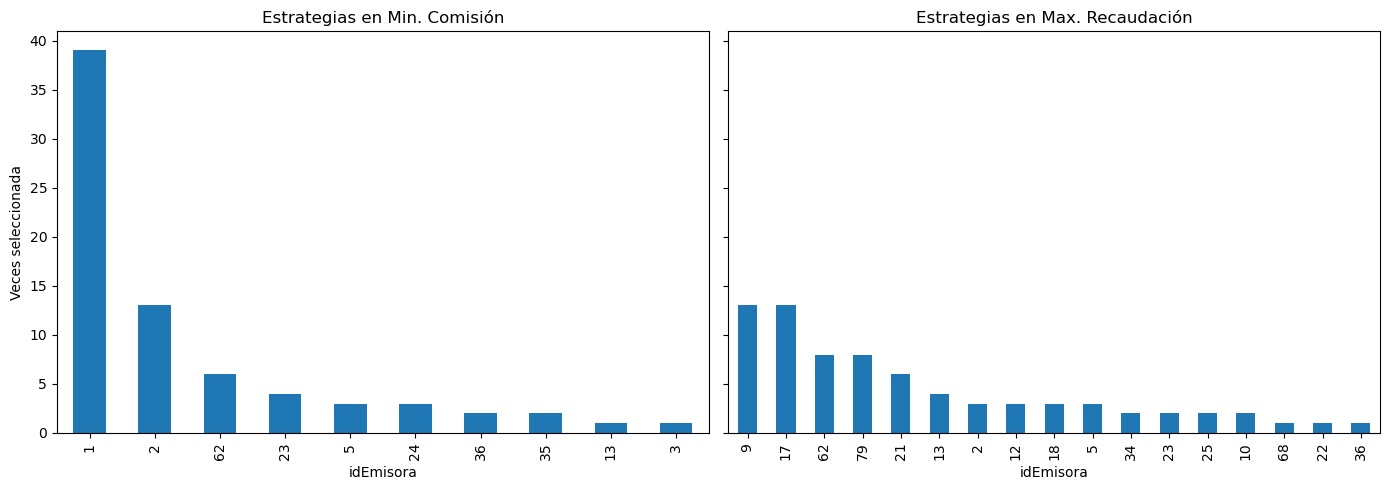


🎯 Comparación directa por crédito:
mejor_en
B    73
A     1
Name: count, dtype: int64


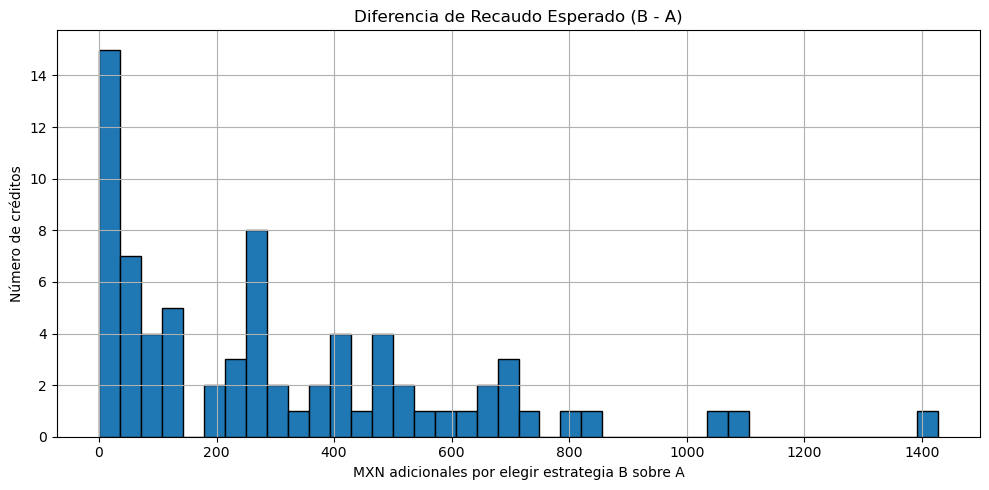

In [42]:
import matplotlib.pyplot as plt

# Separar resultados por escenario
res_min_comision = resultados_simulacion[resultados_simulacion["escenario"] == "Minimizar Comisión"]
res_max_recaudo  = resultados_simulacion[resultados_simulacion["escenario"] == "Maximizar Recaudación"]

# Métricas agregadas por escenario
def resumen_metricas(df):
    return {
        "n_creditos":             df["idCredito"].nunique(),
        "estrategias_usadas":     df["idEmisora"].nunique(),
        "costo_promedio":         df["costoTransaccion"].mean(),
        "probabilidad_promedio":  df["proba_exito"].mean(),
        "recaudo_esperado_prom":  df["expected_recaudo"].mean()
    }

print("Métricas por escenario:")
print("Escenario A (Minimizar Comisión):")
print(resumen_metricas(res_min_comision))
print("Escenario B (Maximizar Recaudación):")
print(resumen_metricas(res_max_recaudo))

# Conteo de uso de estrategias
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

res_min_comision["idEmisora"].value_counts().sort_values(ascending=False).plot(
    kind="bar", ax=axs[0], title="Estrategias en Min. Comisión"
)
res_max_recaudo["idEmisora"].value_counts().sort_values(ascending=False).plot(
    kind="bar", ax=axs[1], title="Estrategias en Max. Recaudación"
)

axs[0].set_ylabel("Veces seleccionada")
axs[0].set_xlabel("idEmisora")
axs[1].set_xlabel("idEmisora")
plt.tight_layout()
plt.show()

# Comparación directa por crédito
comparacion = res_min_comision.merge(
    res_max_recaudo,
    on="idCredito",
    suffixes=("_A", "_B")
)

comparacion["mejor_en"] = comparacion.apply(
    lambda row: "A" if row["expected_recaudo_A"] >= row["expected_recaudo_B"] else "B",
    axis=1
)

print("\n🎯 Comparación directa por crédito:")
print(comparacion["mejor_en"].value_counts())

# Visualizar diferencias de recaudo esperado
plt.figure(figsize=(10,5))
plt.hist(
    comparacion["expected_recaudo_B"] - comparacion["expected_recaudo_A"],
    bins=40, edgecolor="black"
)
plt.title("Diferencia de Recaudo Esperado (B - A)")
plt.xlabel("MXN adicionales por elegir estrategia B sobre A")
plt.ylabel("Número de créditos")
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
def simular_estrategias_por_credito(
    ejemplos_base, model_path, X_model_columns, estr_info,
    umbral=0.05
):
    """
    Simula la elección óptima de estrategia para un conjunto de créditos dados.

    Parámetros:
    - ejemplos_base: DataFrame con un intento por crédito, con columnas necesarias menos 'idEmisora', 'costo', 'cobraSoloExitoso'
    - model_path: ruta al archivo .joblib o .pkl que contiene el modelo entrenado
    - X_model_columns: columnas usadas en entrenamiento (X_encoded.columns)
    - estr_info: DataFrame con columnas [idEmisora, costo, cobraSoloExitoso]
    - umbral: probabilidad mínima para considerar una estrategia válida en escenario A

    Retorna:
    - DataFrame con las estrategias seleccionadas para cada escenario
    """
    import pandas as pd
    import joblib

    # Cargar modelo desde archivo
    clf = joblib.load(model_path)

    resultados = []

    for _, base in ejemplos_base.iterrows():
        mejorA = None
        mejorB = None

        for _, estr in estr_info.iterrows():
            idE     = estr["idEmisora"]
            costo   = estr["costo"]
            cobra   = estr["cobraSoloExitoso"]

            # Armar features del ejemplo con esta estrategia
            fila = {
                "idEmisora":            idE,
                "montoExigible":        base["montoExigible"],
                "montoCobrar":          base["montoCobrar"],
                "num_intentos_previos": base["num_intentos_previos"],
                "num_exitos_previos":   base["num_exitos_previos"],
                "es_segundo_intento":   base["es_segundo_intento"],
                "costo":                costo,
                "cobraSoloExitoso":     cobra,
                "pagare":               base["pagare"],
                "capital":              base["capital"]
            }

            dfX = pd.DataFrame([fila])
            dfX_encoded = pd.get_dummies(dfX, columns=["idEmisora", "cobraSoloExitoso"])
            dfX_encoded = dfX_encoded.reindex(columns=X_model_columns, fill_value=0)

            proba = clf.predict_proba(dfX_encoded)[0, 1]
            exp_rec = proba * base["montoCobrar"]

            # Escenario A: Minimizar costo por encima del umbral
            if proba >= umbral and base["respuestaCategoria"] != "cuenta_invalida":
                if mejorA is None or costo < mejorA[0]:
                    mejorA = (costo, {
                        "idCredito":        base["idCredito"],
                        "consecutivoCobro": base["consecutivoCobro"],
                        "idBanco":          base["idBanco"],
                        "idEmisora":        idE,
                        "proba_exito":      proba,
                        "costoTransaccion": costo,
                        "expected_recaudo": exp_rec,
                        "escenario":        "Minimizar Comisión"
                    })

            # Escenario B: Maximizar recaudación esperada
            if mejorB is None or exp_rec > mejorB[0]:
                mejorB = (exp_rec, {
                    "idCredito":        base["idCredito"],
                    "consecutivoCobro": base["consecutivoCobro"],
                    "idBanco":          base["idBanco"],
                    "idEmisora":        idE,
                    "proba_exito":      proba,
                    "costoTransaccion": costo,
                    "expected_recaudo": exp_rec,
                    "escenario":        "Maximizar Recaudación"
                })

        if mejorA:
            resultados.append(mejorA[1])
        if mejorB:
            resultados.append(mejorB[1])

    return pd.DataFrame(resultados)


In [43]:
from joblib import dump
modelo_path = "/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/modelo_rf.joblib"
dump(clf, modelo_path)

print(f"Modelo guardado en: {modelo_path}")

Modelo guardado en: /Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/modelo_rf.joblib


In [46]:
resultado = simular_estrategias_por_credito(
    ejemplos_base=ejemplos_base10,
    model_path=modelo_path,
    X_model_columns=X_train.columns, 
    estr_info=estr_info,
    umbral=0.05
)
print(resultado.head())

   idCredito  consecutivoCobro  idBanco  idEmisora  proba_exito  \
0     436248          41465324       72          2         0.07   
1     436248          41465324       72          9         0.13   
2     715162          44059563       14          1         0.29   
3     715162          44059563       14          9         0.99   
4     421803          31457423       12          1         0.33   

   costoTransaccion  expected_recaudo              escenario  
0              1.75          139.9930     Minimizar Comisión  
1              2.82          259.9870  Maximizar Recaudación  
2              1.75          185.0229     Minimizar Comisión  
3              2.82          631.6299  Maximizar Recaudación  
4              1.75          580.7967     Minimizar Comisión  
